## Machine learning financiero aplicado a la predicción del EUR/USD

#### TFG realizado por Iñaki Gangutia Arrázola y dirigido por Javier Martínez Rodríguez

In [4]:
# Python version: 3.11.7

import numpy as np   # numpy version: 1.26.4
import random 
import pandas as pd   # pandas version: 2.1.4
import matplotlib.pyplot as plt   # matplotlib version: 3.10.0
import seaborn as sns   # seaborn version: 0.13.2
import os

from scipy import stats   # scipy version: 1.14.1
from scipy.stats import zscore, weightedtau
from arch.unitroot import ADF   # arch version: 7.2.0

import yfinance as yf   # yfinance version: 0.2.54
import pandas_datareader.data as pdr   # pandas_datareader version: 0.10.0
from ecbdata import ecbdata as ecb   # ecbdata version: 0.0.9

import xgboost as xgb   # xgboost version: 2.1.1
from sklearn.linear_model import LogisticRegression   # sklearn version: 1.5.1
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [5]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

### 1. Data Collection

#### Descarga de datos para variables independientes (X)

Establecemos las fechas de inicio y fin de nuestros datos.

In [10]:
start = '2015-01-01'
end = '2025-01-01'

Yahoo Data, https://finance.yahoo.com/markets/

In [13]:
tickers = [
    # Foreign Exchange (FX)
    'CNY=X',  # USD/CNY (Yuan Chino)
    'JPY=X',  # USD/JPY (Yen Japonés)
    'GBPUSD=X',  # Libra Esterlina
    'EURCAD=X',  # Canadian Dollar
    'AUDUSD=X',  # Australian Dollar
    'EURCHF=X',  # Swiss Franc
    'NZDUSD=X',  # New Zealand Dollar (Kiwi)

    # Commodities
    'CL=F',  # Oil (WTI)
    'BZ=F',  # Oil (Brent)
    'NG=F',  # Natural Gas
    'GC=F',  # Gold
    'SI=F',  # Silver
    'HG=F',  # Copper
    'PL=F',  # Platinum
    'ZS=F',  # Soybeans
    'KE=F',  # Wheat
    'ZC=F',  # Corn
    'SB=F',  # Sugar
    'CT=F',  # Cotton

    # Indices
    '^GSPC',  # S&P 500
    '^RUT',  # Russell 2000
    '^STOXX50E',  # EURO STOXX 50
    '^N100',  # Euronext 100 Index
    '^FTSE',  # UK
    '^GDAXI',  # Germany
    '^FCHI',  # France

    # Individual Stocks (World top 45 by revenue)
    #'2222.SR',  # Eliminada por diferencia en calendario (días semana de cotización / calendario musulmán)
    'BRK-B',
    'AAPL',
    'GOOG',
    'MSFT',
    'JPM',
    'NVDA',
    'META',
    'AMZN',
    #'1398.HK',  # Eliminada Hong Kong por diferencias de calendario
    #'601939.SS',  # Eliminadas Shangai por diferencia de calendario
    #'601601.SS',
    'XOM',
    'TM',
    #'601288.SS',
    'TSM',
    #'601988.SS',
    #'0857.HK',
    'HSBC',
    'EQNR',
    'TTE',
    'WMT',
    #'005930.KS',  # Eliminada South Korea por diferencias de calendario
    'SHEL',
    #'0883.HK',
    'TCEHY',
    'CVX',
    'BAC',
    #'3968.HK',
    #'0941.HK',
    'V',
    'CDI.PA',
    'VZ',
    'BABA',
    'BN',
    #'601318.SS',
    'HD',
    'WFC',
    'FNMA',
    'SAN',
    'PG',
    'UNH',
    'VOW3.DE',
    'PBR',
    'NVO',

    # Cryptocurrencies
    'BTC-USD'  # Bitcoin
]

data = yf.download(
    tickers, 
    start=start,
    end=end
    )['Close']

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  60 of 60 completed


Ticker,AAPL,AMZN,AUDUSD=X,BABA,BAC,BN,BRK-B,BTC-USD,BZ=F,CDI.PA,...,XOM,ZC=F,ZS=F,^FCHI,^FTSE,^GDAXI,^GSPC,^N100,^RUT,^STOXX50E
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,0.817127,NaN,NaN,NaN,NaN,314.248993,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.288584,15.426000,0.817795,100.051346,14.441475,16.365538,149.169998,315.032013,56.419998,119.728958,...,58.967136,395.75,1002.50,4252.290039,6547.799805,9764.730469,2058.199951,835.969971,1198.800049,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.082001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.195007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.604332,15.109500,0.806777,97.540413,14.021950,16.199673,147.000000,274.473999,53.110001,116.914246,...,57.353699,406.00,1039.75,4111.359863,6417.200195,9473.160156,2020.579956,811.789978,1181.349976,3023.139893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,254.974930,223.750000,0.622301,85.059998,44.061939,57.084179,456.510010,94164.859375,74.169998,589.838928,...,104.572884,454.00,980.00,7355.370117,8149.799805,19984.320312,5970.839844,1450.270020,2244.590088,4898.879883
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95163.929688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93530.226562,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Federal Reserve System (FED) Data, https://fred.stlouisfed.org/

In [16]:
requests = [
    # Rates
    'DFF',  # EFFR: Effective Federal Funds Rate

    # REPO
    'RRPONTSYD',  # OREPO: Overnight Reverse Repurchase Agreements
    
    # U.S. Bonds
    'DGS3MO',  # Tresuary Yield 3M
    'DGS1',  # Tresuary Yield 1Y
    'DGS2',  # Tresuary Yield 2Y
    'DGS5',  # Tresuary Yield 5Y
    'DGS10',  # Tresury Yield 10Y
    'DGS20',  # Tresury Yield 20Y
    'DGS30',  # Tresury Yield 30Y
    'T10Y2Y',  # US Yield Curve

    # Corporate Bonds
    'DAAA',  # Moody's Seasoned Aaa Corporate Bond Yield
    'DBAA'  # Moody's Seasoned Baa Corporate Bond Yield
]

FED = pdr.DataReader(
    requests, 
    'fred', 
    start=start,
    end=end
)

FED.rename(columns={'DFF': 'USEFFR', 
                    'RRPONTSYD': 'USREPO', 
                    'T10Y2Y': 'UST10Y2Y'
                   }, 
           inplace=True)

FED

,USEFFR,USREPO,DGS3MO,DGS1,DGS2,DGS5,DGS10,DGS20,DGS30,UST10Y2Y,DAAA,DBAA
DATE,,,,,,,,,,,,
2015-01-01,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.12,42.186,0.02,0.25,0.66,1.61,2.12,2.41,2.69,1.46,3.67,4.63
2015-01-03,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.12,164.177,0.03,0.26,0.68,1.57,2.04,2.32,2.60,1.36,3.59,4.56
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28,4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,4.33,260.743,4.37,4.17,4.24,4.37,4.55,4.84,4.77,0.31,5.35,5.98


European Central Bank (ECB) Data, https://data.ecb.europa.eu/data/data-categories

In [19]:
series = [
    # Rates
    'FM.D.U2.EUR.4F.KR.DFR.LEV',  # Deposit facility
    'FM.D.U2.EUR.4F.KR.MLFR.LEV',  # Marginal lending facility
    'FM.D.U2.EUR.4F.KR.MRR_FR.LEV',  # Main refinancing operations
    
    # Euro area Bonds
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_3M',  # Bond rate 3M (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_1Y',  # Bond rate 1Y (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_2Y',  # Bond rate 2Y (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_5Y',  # Bond rate 5Y (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_10Y',  # Bond rate 10Y (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_20Y',  # Bond rate 20Y (all rating issuers)
    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_30Y',  # Bond rate 30Y (all rating issuers)

    # STEP (Short-Term European Paper)
    'STP.B.A1.1000.A.XXXX.R.AA.RA.1.A.EUR.E'  # Outstanding amounts of STEP instruments denominated in EUR, issued by total economy (all ratings), World (all entities)
]

ECB = pd.DataFrame(index=data.index)

for serie in series:
    ECB_n = ecb.get_series(
        serie,
        start=start, 
        end=end
    )

    ECB_n = ECB_n[['TIME_PERIOD', 'OBS_VALUE']].set_index('TIME_PERIOD')
    ECB_n.index = pd.to_datetime(ECB_n.index)

    ECB[serie] = ECB_n

ECB.rename(columns={'FM.D.U2.EUR.4F.KR.DFR.LEV': 'EUDF', 
                    'FM.D.U2.EUR.4F.KR.MLFR.LEV': 'EULF',
                    'FM.D.U2.EUR.4F.KR.MRR_FR.LEV': 'EUMRO',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_3M': 'EU3M',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_1Y': 'EU1Y',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_2Y': 'EU2Y',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_5Y': 'EU5Y',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_10Y': 'EU10Y',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_20Y': 'EU20Y',
                    'YC.B.U2.EUR.4F.G_N_C.SV_C_YM.SR_30Y': 'EU30Y',
                    'STP.B.A1.1000.A.XXXX.R.AA.RA.1.A.EUR.E': 'EUSTEP'}, 
           inplace=True)

ECB['EUT10Y2Y'] = ECB['EU10Y'] - ECB['EU2Y']  # EU Yield Curve

ECB

,EUDF,EULF,EUMRO,EU3M,EU1Y,EU2Y,EU5Y,EU10Y,EU20Y,EU30Y,EUSTEP,EUT10Y2Y
Date,,,,,,,,,,,,
2015-01-01,-0.2,0.3,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261639.0,NaN
2015-01-02,-0.2,0.3,0.05,0.040941,0.086179,0.116876,0.396964,1.158300,2.024878,2.359584,256955.0,1.041423
2015-01-03,-0.2,0.3,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,-0.2,0.3,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.2,0.3,0.05,0.042616,0.092589,0.128025,0.411269,1.164797,2.021210,2.352067,255785.0,1.036773
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,3.0,3.4,3.15,2.704354,2.256606,2.163627,2.505090,2.984634,3.316245,3.264120,350123.0,0.821007
2024-12-28,3.0,3.4,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,3.0,3.4,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merge a un solo `DataFrame`.

In [314]:
X = data.merge(FED, how='outer', left_index=True, right_index=True).merge(ECB, how='outer', left_index=True, right_index=True)
X.index.name = 'Dates'
X

,AAPL,AMZN,AUDUSD=X,BABA,BAC,BN,BRK-B,BTC-USD,BZ=F,CDI.PA,...,EUMRO,EU3M,EU1Y,EU2Y,EU5Y,EU10Y,EU20Y,EU30Y,EUSTEP,EUT10Y2Y
Dates,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,0.817127,NaN,NaN,NaN,NaN,314.248993,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261639.0,NaN
2015-01-02,24.288584,15.426000,0.817795,100.051346,14.441475,16.365538,149.169998,315.032013,56.419998,119.728958,...,0.05,0.040941,0.086179,0.116876,0.396964,1.158300,2.024878,2.359584,256955.0,1.041423
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.082001,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.195007,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.604332,15.109500,0.806777,97.540413,14.021950,16.199673,147.000000,274.473999,53.110001,116.914246,...,0.05,0.042616,0.092589,0.128025,0.411269,1.164797,2.021210,2.352067,255785.0,1.036773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95163.929688,NaN,NaN,...,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93530.226562,NaN,NaN,...,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-30,251.593094,221.300003,0.622510,84.129997,43.634636,57.243885,452.160004,92643.210938,74.389999,587.379211,...,3.15,2.695816,2.261504,2.177953,2.522233,3.000785,3.338045,3.292139,346735.0,0.822832


#### Descarga de datos para variable dependiente (y)

In [298]:
data_y = yf.download(
    'EURUSD=X', 
    start=start,
    end=end
    )

data_y.columns = data_y.columns.droplevel(1)
data_y = data_y[['Close']]

data_y

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536
...,...
2024-12-25,1.040258
2024-12-26,1.039955
2024-12-27,1.042318


#### (Opcional) Guardar datos para utilizar sin conexión.

Gruardamos los datos del `DataFrame` X y data_y.

In [316]:
'''
X.to_csv('TFG_data_X.csv', index=True)
data_y.to_csv('TFG_data_y.csv', index=True)
'''

### 2. Data Processing & Cleaning

In [318]:
#'''
X = pd.read_csv('TFG_data_X.csv', parse_dates=['Dates'], index_col='Dates')
data_y = pd.read_csv('TFG_data_y.csv', parse_dates=['Date'], index_col='Date', date_format='%m/%d/%y')
#'''

Conteo de valores `NaN` y duplicados.

In [36]:
print(f"Total NaN X: {X.isna().sum().sum()} \nTotal NaN y: {data_y.isna().sum().sum()} \n\nTotal Duplicates X: {X.duplicated().sum()} \nTotal Duplicates y: {data_y.duplicated().sum()}")

Total NaN X: 88924 
Total NaN y: 0 

Total Duplicates X: 0 
Total Duplicates y: 331


Comprobamos que activos poseen el mayor número de `NaN` en businessweek.

In [39]:
business_days = pd.bdate_range(start=X.index.min(), end=X.index.max())
X = X.reindex(business_days)

X_nans = X.isna().sum()
X_nans.sort_values()

USEFFR        0
EUSTEP        1
BTC-USD       1
EUMRO         1
EULF          1
           ... 
DGS2        109
DGS1        109
DGS3MO      109
UST10Y2Y    109
USREPO      118
Length: 84, dtype: int64

Eliminamos `NaN`.

In [42]:
X = X.dropna()
data_y = data_y.dropna()

In [43]:
print(f"Total NaN X: {X.isna().sum().sum()} \nTotal NaN y: {data_y.isna().sum().sum()} \n\nX shape: {X.shape} \ny shape: {data_y.shape}")

Total NaN X: 0 
Total NaN y: 0 

X shape: (2381, 84) 
y shape: (2606, 1)


### 3. Exploratory Data Analysis (EDA)

Ploteamos la variable y. Apreviamos visualmente que no es estacionaria y realizando el test de `Dickey-Fuller` obtenemos un p-value no significativo por lo que asumimos $H_0$ no estacionariedad.

In [48]:
y = data_y['Close']

Augmented Dickey-Fuller test: 0.06


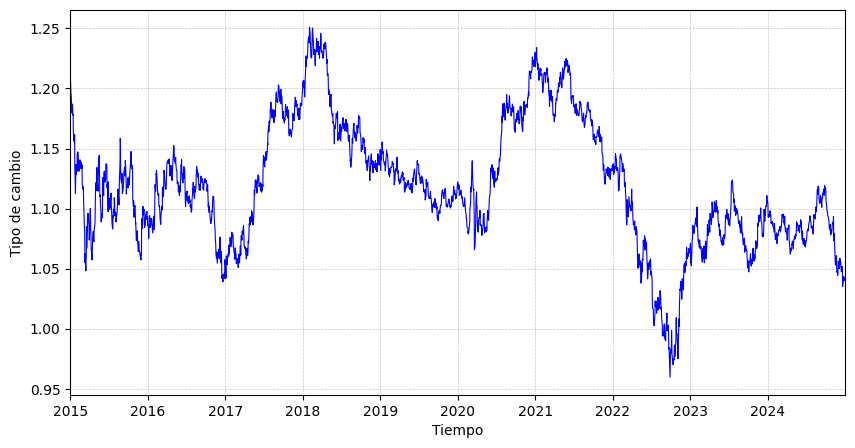

In [49]:
print(f"Augmented Dickey-Fuller test: {np.round(ADF(y).pvalue, 2)}")

plt.figure(figsize=(10, 5))
plt.plot(y.index, y, linewidth=0.8, color='blue')

plt.xlim(y.index.min(), y.index.max())
plt.xlabel('Tiempo')
plt.ylabel('Tipo de cambio')
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

Realizamos un Q-Q Plot / Probability Plot sobre los retornos, visualmente apreciamos que las colas son más largas que una distribución normal / Gaussiana, confirmamos esto con el test `Jarque-Bera` obteniendo un p-value significativo, asumiendo así $H_1$ no normalidad en la distribución.

Jarque-Bera test: 0.0


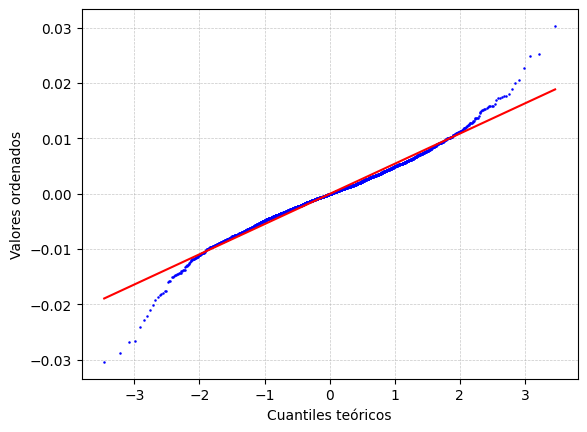

In [52]:
print(f"Jarque-Bera test: {np.round(stats.jarque_bera(y.diff().dropna())[1], 2)}")

stats.probplot(y.diff().dropna(), dist="norm", plot=plt)

plt.gca().get_lines()[0].set_markersize(0.8)
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Valores ordenados')
plt.title('')
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

### 4. Feature Engineering

#### Binary `y` labels

Matcheamos los índices de X e y, incluimos la variable `y` a predecir en $t+1$ aplicando `shift`.

In [58]:
data_y = data_y.loc[X.index]
data_y.loc[:, 't+1'] = data_y.shift(-1)
data_y = data_y.dropna()

Calculamos otros datos de interés.

In [61]:
data_y.loc[:, 'diff'] = data_y['t+1'].diff()
data_y.loc[:, 'pct_change'] = data_y['t+1'].pct_change()
data_y = data_y.dropna().copy()
data_y.loc[:, 'pct_abs'] = np.abs(data_y['pct_change'])


X = X.loc[data_y.index]

print(f"X shape: {X.shape} \ny shape: {data_y.shape}")

X shape: (2379, 84) 
y shape: (2379, 5)


Extraemos las etiquetas / `labels` binarias de `y` sobre los rendimientos, buscando un número igualmente distribuido de etiquetas, señal de compra si (>0), venta si (<=0).

In [64]:
data_y.loc[:, 'label'] = np.where(data_y['diff'] > 0, 1, 0)

In [65]:
y_label = data_y['label']

Observamos que la cantidad de ambas señales es bastante equilibrada.

In [68]:
y_label.value_counts()

label
0    1211
1    1168
Name: count, dtype: int64

#### Fractional differentiation

Función de pesos con ventana fija (Fractional diff Fixed window / FFD) 

In [72]:
def get_weights_FFD(d, thres):
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k+=1
        
    return np.array(w[::-1]).reshape(-1, 1)

Valor de la función segun el valor $d$ y $thres$.

Valor de la función según valor d y thres


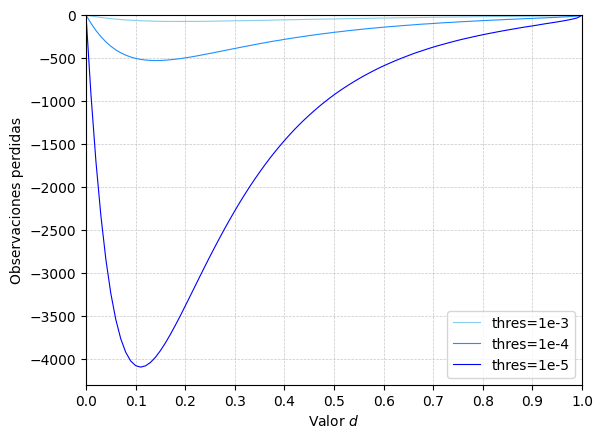

In [75]:
print('Valor de la función según valor d y thres')

d_val_3 = [-len(get_weights_FFD(d, 1e-3)) for d in np.linspace(0, 1, 101)]
d_val_4 = [-len(get_weights_FFD(d, 1e-4)) for d in np.linspace(0, 1, 101)]
d_val_5 = [-len(get_weights_FFD(d, 1e-5)) for d in np.linspace(0, 1, 101)]
x_val = np.linspace(0, 1, len(d_val_3))

plt.plot(x_val, d_val_3, linewidth=0.8, color='skyblue', label='thres=1e-3')
plt.plot(x_val, d_val_4, linewidth=0.8, color='dodgerblue', label='thres=1e-4')
plt.plot(x_val, d_val_5, linewidth=0.8, color='blue', label='thres=1e-5')

plt.xlim(0, 1)
plt.ylim(min(d_val_5)*1.05, 0)
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel(f'Valor $d$')
plt.ylabel('Observaciones perdidas')
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

Comprobamos precisión de `thresh` a utilizar, este no debe exceder utilizando la función de pesos la longitud de nuestros datos `X` el intervalo [0,1] de forma recomendable.

In [78]:
print(f'Len extrema función get_weights_FFD(): {len(get_weights_FFD(0.14, 1e-4))} \nLen de X: {X.shape[0]}')

Len extrema función get_weights_FFD(): 528 
Len de X: 2379


Función de diferenciación fraccionaria FFD.

In [81]:
def frac_diff_FFD(ts, d=1, thres=1e-4, d_optimum=False, d_list=False, pval=0.05):
    '''
    ts: pandas Series format
    d: must be positive
    thresh: cut-off weight for the window
    optimum: if True computes the optimum value for d
    d_list: if True returns the value of d used
    '''
    if d_optimum == True:
        d = bisection_method_FFD(ts, thres=thres, pval=pval)
    
    w = get_weights_FFD(d, thres)
    w_T = w.T.reshape(-1)
    width = len(w) - 1

    tsF = ts.dropna().to_numpy()
    indexF = ts.dropna().index
    ts_ = np.empty(len(tsF) - width)

    for i in range(width, len(tsF)):
        ts_[i - width] = np.dot(w_T, tsF[i - width: i + 1])

    if d_list == True:
        return pd.Series(ts_, index=indexF[width:]), np.round(d, 4)
    
    return pd.Series(ts_, index=indexF[width:])

Función del parámetro a optimizar, p-valor < 0.05 (95% confianza), ajustado de longitud opcional.

In [84]:
def optim_obj(ts, d, fixed, pval):
    frac_diff_ts = frac_diff_FFD(ts, d)
    
    if fixed is not False:
        frac_diff_ts = frac_diff_ts.loc[fixed].dropna()
        
    p_value = ADF(frac_diff_ts).pvalue
    return (p_value - pval)

Función que optimiza el valor $d$ mediante método de la bisección modificado, además se implementa una segunda capa para evitar mínimos locales, ya que la "función" no es totalmente estable.

In [87]:
1e-4 > (1/(2**14))

True

In [88]:
def bisection_method_FFD(ts, thres, minimum=0, maximum=1, fixed=False, pval=0.05):
    '''
    ts: pandas Series format
    thresh: cut-off weight for the window
    minimum: min value range
    maximum: max value range
    fixed: index to adjust (restriction)
    '''
    p_tol = 0.0002
    iter_count = 0
    max_iter = 12

    # L1
    while iter_count < max_iter:
        mid = np.round((minimum + maximum) / 2, 4)
        p_value_mid = optim_obj(ts, d=mid, fixed=fixed, pval=pval)
        
        if -p_tol < p_value_mid < 0:
            break
        elif p_value_mid < -p_tol:
            maximum = mid
        else:
            minimum = mid
        iter_count += 1

    # L2
    r_maximum = np.round(mid + thres*3, 4)
    r_minimum = np.round(mid - thres*3, 4)
    
    l2_d = np.linspace(r_minimum, r_maximum, 7) 
    l2_p = [optim_obj(ts, d=d, fixed=fixed, pval=pval) for d in l2_d]
    p_val_neg = [(p_val, d) for p_val, d in zip(l2_p, l2_d) if p_val < 0 and d >= 0]
    
    if p_val_neg:
        p_max, d_opt = max(p_val_neg, key=lambda x: x[0])
        return np.round(d_opt, 4)
    else:
        return np.round(r_maximum, 4)

Función para aplicar lo previo sobre un conjunto de datos contenidos en un `DataFrame(X)`, ajustándose óptimamente la longitud de cada serie a la longitud con la serie con el menor número de observaciones tras haberla diferenciado fraccionariamente.

In [91]:
def fix_len_df_FFD(df, thres=1e-4, d_optimum=True, d_list=True, stats=False):
    '''
    df: pandas DataFrame format
    thresh: cut-off weight for the window
    d_optimum: optimizes d for each searies/column with the same df length
    stats: returns an extra df with stats as d, p-val,... of each column
    '''
    df_ = pd.DataFrame(columns=df.columns, index=df.index)
    d_ = pd.DataFrame(index=df.columns, columns=['d', 'd_adj', 'd_diff', 'pval', 'pval_adj', '<0.05', '<0.05_'])
    
    for col in df.columns:
        df_[col], d_.loc[col, 'd'] = frac_diff_FFD(df[col], thres=thres, d_optimum=True, d_list=True)
        p_value = ADF(df_[col].dropna()).pvalue
        d_.loc[col, '<0.05'] = p_value < 0.05
        d_.loc[col, 'pval'] = np.round(p_value, 3)
        

    index_adj = df_.dropna().index
    df_fix = pd.DataFrame(columns=df.columns, index=index_adj)
    
    for col in df.columns:
        d_adj = bisection_method_FFD(df[col], thres, fixed=index_adj)
        df_fix[col] = frac_diff_FFD(df[col], d=d_adj, thres=thres, d_optimum=False, d_list=False)
        
        d_.loc[col, 'd_adj'] = d_adj
        p_value_adj = ADF(df_fix[col].dropna()).pvalue
        d_.loc[col, '<0.05_'] = p_value_adj < 0.05
        d_.loc[col, 'pval_adj'] = np.round(p_value_adj, 3)
        d_.loc[col, 'd_diff'] = d_.loc[col, 'd'] - d_.loc[col, 'd_adj']

    if stats == True:
        stationary_all = np.all(np.all(d_['<0.05']) & np.all(d_['<0.05_']))
        print(f'Todas las series estacionarias: {stationary_all}')
        d_ = d_.drop(columns=['<0.05', '<0.05_'])
        return df_fix, d_

    else:
        return df_fix

Diferenciación entera `d=1` (integer diff).

In [94]:
X_int_diff = X.diff().dropna()
y_int = y.loc[X_int_diff.index]

Diferenciación fraccionaria con ventana fija (fractional diff fixed window, adjusted len). Obtenemos la diferenciación fraccionaria óptima y estadísticos relacionados para cada serie temporal individualmente.

In [97]:
X_frac_diff, X_frac_stats = fix_len_df_FFD(X, stats=True)
y_frac = y.loc[X_frac_diff.index]

Todas las series estacionarias: True


Estadísticos de la diferenciación óptima individual de cada serie.

In [100]:
print(X_frac_stats.to_string())

                d   d_adj  d_diff   pval pval_adj
AAPL       0.5065  0.4194  0.0871   0.05     0.05
AMZN       0.4336  0.3953  0.0383   0.05     0.05
AUDUSD=X   0.1427  0.1427     0.0   0.05     0.05
BABA       0.2835   0.293 -0.0095   0.05     0.05
BAC        0.2584  0.2639 -0.0055  0.046     0.05
BN          0.382  0.3507  0.0313  0.048     0.05
BRK-B      0.4887  0.3453  0.1434   0.05     0.05
BTC-USD      0.41  0.4138 -0.0038   0.05     0.05
BZ=F       0.1612  0.1628 -0.0016   0.05     0.05
CDI.PA      0.375  0.3796 -0.0046   0.05     0.05
CL=F       0.1702  0.1728 -0.0026   0.05     0.05
CNY=X      0.3027  0.3211 -0.0184   0.05     0.05
CT=F       0.1268   0.127 -0.0002   0.05     0.05
CVX        0.2469  0.2461  0.0008  0.049     0.05
EQNR       0.2679   0.272 -0.0041   0.05     0.05
EURCAD=X   0.0004  0.0607 -0.0603  0.023     0.05
EURCHF=X   0.3474  0.3673 -0.0199   0.05     0.05
FNMA       0.0544  0.1269 -0.0725   0.05     0.05
GBPUSD=X   0.0077  0.0152 -0.0075  0.045     0.05


Mostramos la comparativa entre las 4 formas de la serie temporal: original, diferenciación fraccionaria óptima, diferenciación fraccionaria general y diferenciación unitaria.

ADF test (original): 0.55
ADF test (frac_diff): 0.05


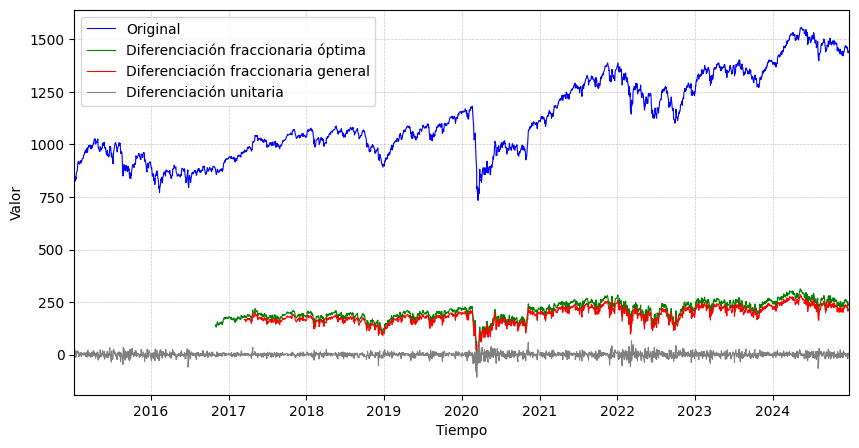

In [103]:
tic = '^N100'

print(f"ADF test (original): {np.round(ADF(X[tic]).pvalue, 2)}")
print(f"ADF test (frac_diff): {np.round(ADF(X_frac_diff[tic].dropna()).pvalue, 3)}")

X_frac_tic = frac_diff_FFD(X[tic], d=X_frac_stats.loc[tic].d)

plt.figure(figsize=(10, 5))
plt.plot(X.index, X[tic], linewidth=0.8, color='blue', label='Original')
plt.plot(X_frac_tic.index, X_frac_tic, linewidth=0.8, color='green', label='Diferenciación fraccionaria óptima')
plt.plot(X_frac_diff.index, X_frac_diff[tic], linewidth=0.8, color='red', label='Diferenciación fraccionaria general')
plt.plot(X_int_diff.index, X_int_diff[tic], linewidth=0.8, color='grey', label='Diferenciación unitaria')

plt.xlim(X.index.min(), X.index.max())
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.show()

Plot `test ADF` y `correlación` en el intevalo [0, 1].

In [106]:
def plot_min_FFD(ts, minimum=0, maximum=1, h=11):
    linspace = np.linspace(minimum, maximum, h)
    stats = pd.DataFrame(columns=['ADF', 'pval', 'lags', 'n_obs', '95%_conf', 'corr'], index=linspace)
    ts0 = ts.dropna()
    
    for d in linspace:
        ts2 = frac_diff_FFD(ts0, d).dropna()
        ts1 = ts0.loc[ts2.index]
        corr = np.corrcoef(ts1, ts2)[0,1]
        ts2 = ADF(ts2)
        stats.loc[d] = [
            ts2.stat, 
            ts2.pvalue, 
            ts2.lags, 
            ts2.nobs, 
            ts2.critical_values['5%'], 
            corr
        ]

    ts_opt, d_opt = frac_diff_FFD(ts0, d_optimum=True, d_list=True)
    ts_base = ts0.loc[ts_opt.index]
    opt_corr = np.corrcoef(ts_base, ts_opt)[0,1]
    print(f"Correlación en óptimo d={d_opt}: {opt_corr:.2f} \nCorrelación en d=1: {stats.iloc[-1, 5]:.2f}")
    
    ax = stats[['ADF', 'corr']].plot(secondary_y='ADF', color=['blue', 'aqua'], linewidth=1)
    adf_conf_line = plt.axhline(stats['95%_conf'].mean(), linewidth=1, color='red', linestyle='dotted')

    plt.xlim(0, 1)
    ax.set_xlabel(f'Valor $d$')
    ax.set_ylabel('Correlación', color='aqua')
    ax.right_ax.set_ylabel('Estadístico ADF', color='blue')
    
    adfs, ladfs = ax.right_ax.get_legend_handles_labels()
    correl, lcorrel = ax.get_legend_handles_labels()
    ax.legend(adfs + correl + [adf_conf_line], ['Estadístico ADF'] + ['Correlación'] + ['ADF 95% conf'])
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

Correlación en óptimo d=0.448: 0.76 
Correlación en d=1: 0.03


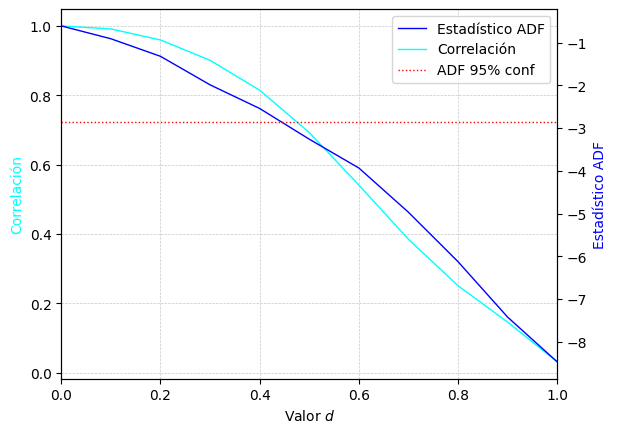

In [107]:
plot_min_FFD(X['EU5Y'])

#### Principal Component Analysis (PCA) Orthogonal

Planteamos el conjunto de funciones para hacer las variables ortogonales y evitar efectos de sustitución / multi-colinealidad.

In [112]:
def get_eVec(dot, varThres):
    eVal, eVec = np.linalg.eigh(dot)
    idx = eVal.argsort()[::-1]
    eVal, eVec = eVal[idx], eVec[:, idx]
    
    eVal = pd.Series(eVal, index=['PC_' + str(i+1) for i in range(eVal.shape[0])]) 
    eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index) 
    eVec = eVec.loc[:, eVal.index]
    
    cumVar = eVal.cumsum() / eVal.sum()
    dim = cumVar.values.searchsorted(varThres) 
    eVal, eVec = eVal.iloc[:dim+1], eVec.iloc[:, :dim+1]
    
    return eVal, eVec

In [113]:
def orthoFeats(dfX, varThres=0.95, eVl=False, eVc=False):
    dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1)
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    dfP = pd.DataFrame(dfP, index=dfX.index, columns=eVal.index)

    if eVl == True:
        return eVal
    elif eVc == True:
        return eVec
    else:
        return dfP

Llamamos a la función.

In [116]:
X_PCA_frac = orthoFeats(X_frac_diff, varThres=0.95)

In [117]:
X_PCA_int = orthoFeats(X_int_diff, varThres=0.95)

Verificamos que no exista correlación entre variables y vemos el número de componentes por $\%$.

In [120]:
PCA_dict = {
    '90% Varianza': orthoFeats(X_frac_diff, varThres=0.9),
    '95% Varianza': orthoFeats(X_frac_diff, varThres=0.95),
    '99% Varianza': orthoFeats(X_frac_diff, varThres=0.99),
}

df_PCA = pd.DataFrame(index=PCA_dict.keys(), columns=['Total Corr', 'Componentes'])

for method, values in PCA_dict.items():
    corr_mx = np.corrcoef(values, rowvar=False)
    corr_sum = corr_mx.sum() - corr_mx.shape[0]

    df_PCA.loc[method, 'Total Corr'] = np.round(corr_sum, 2)
    df_PCA.loc[method, 'Componentes'] = np.shape(values)[1]

df_PCA

,Total Corr,Componentes
90% Varianza,-0.0,20
95% Varianza,-0.0,32
99% Varianza,-0.0,55


Extraemos y ploteamos la varianza explicada por componente.

In [123]:
eVal = orthoFeats(X_frac_diff, varThres=0.95, eVl=True)
eVal = eVal / eVal.sum()
eVal_plot = eVal.sort_values(ascending=True)

Varianza explicada por Componente


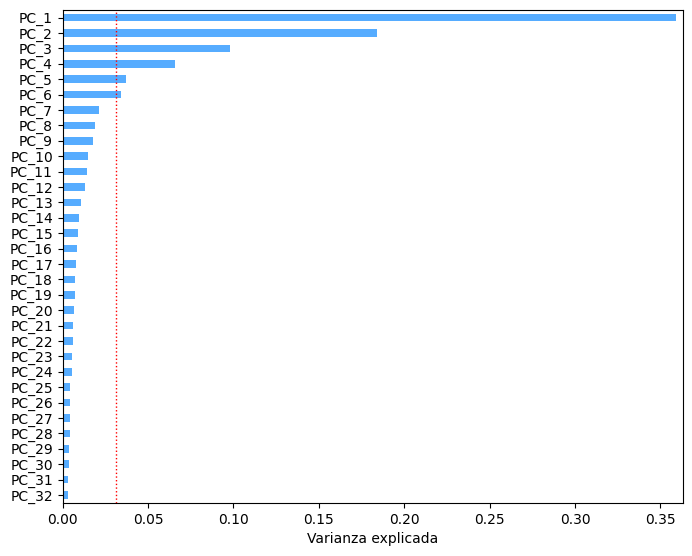

In [124]:
print('Varianza explicada por Componente')

plt.figure(figsize=(8, eVal_plot.shape[0] / 5.)) 
ax = eVal_plot.plot(kind='barh', color='dodgerblue', alpha=0.75)
plt.axvline(sum(eVal_plot) / eVal_plot.shape[0], linewidth=1, color='red', linestyle='dotted')

plt.xlim([0, eVal_plot.max()*1.01])
plt.xlabel('Varianza explicada')
plt.show()

Heatmap de los componentes creados por el PCA, no hay correlación entre ellos.

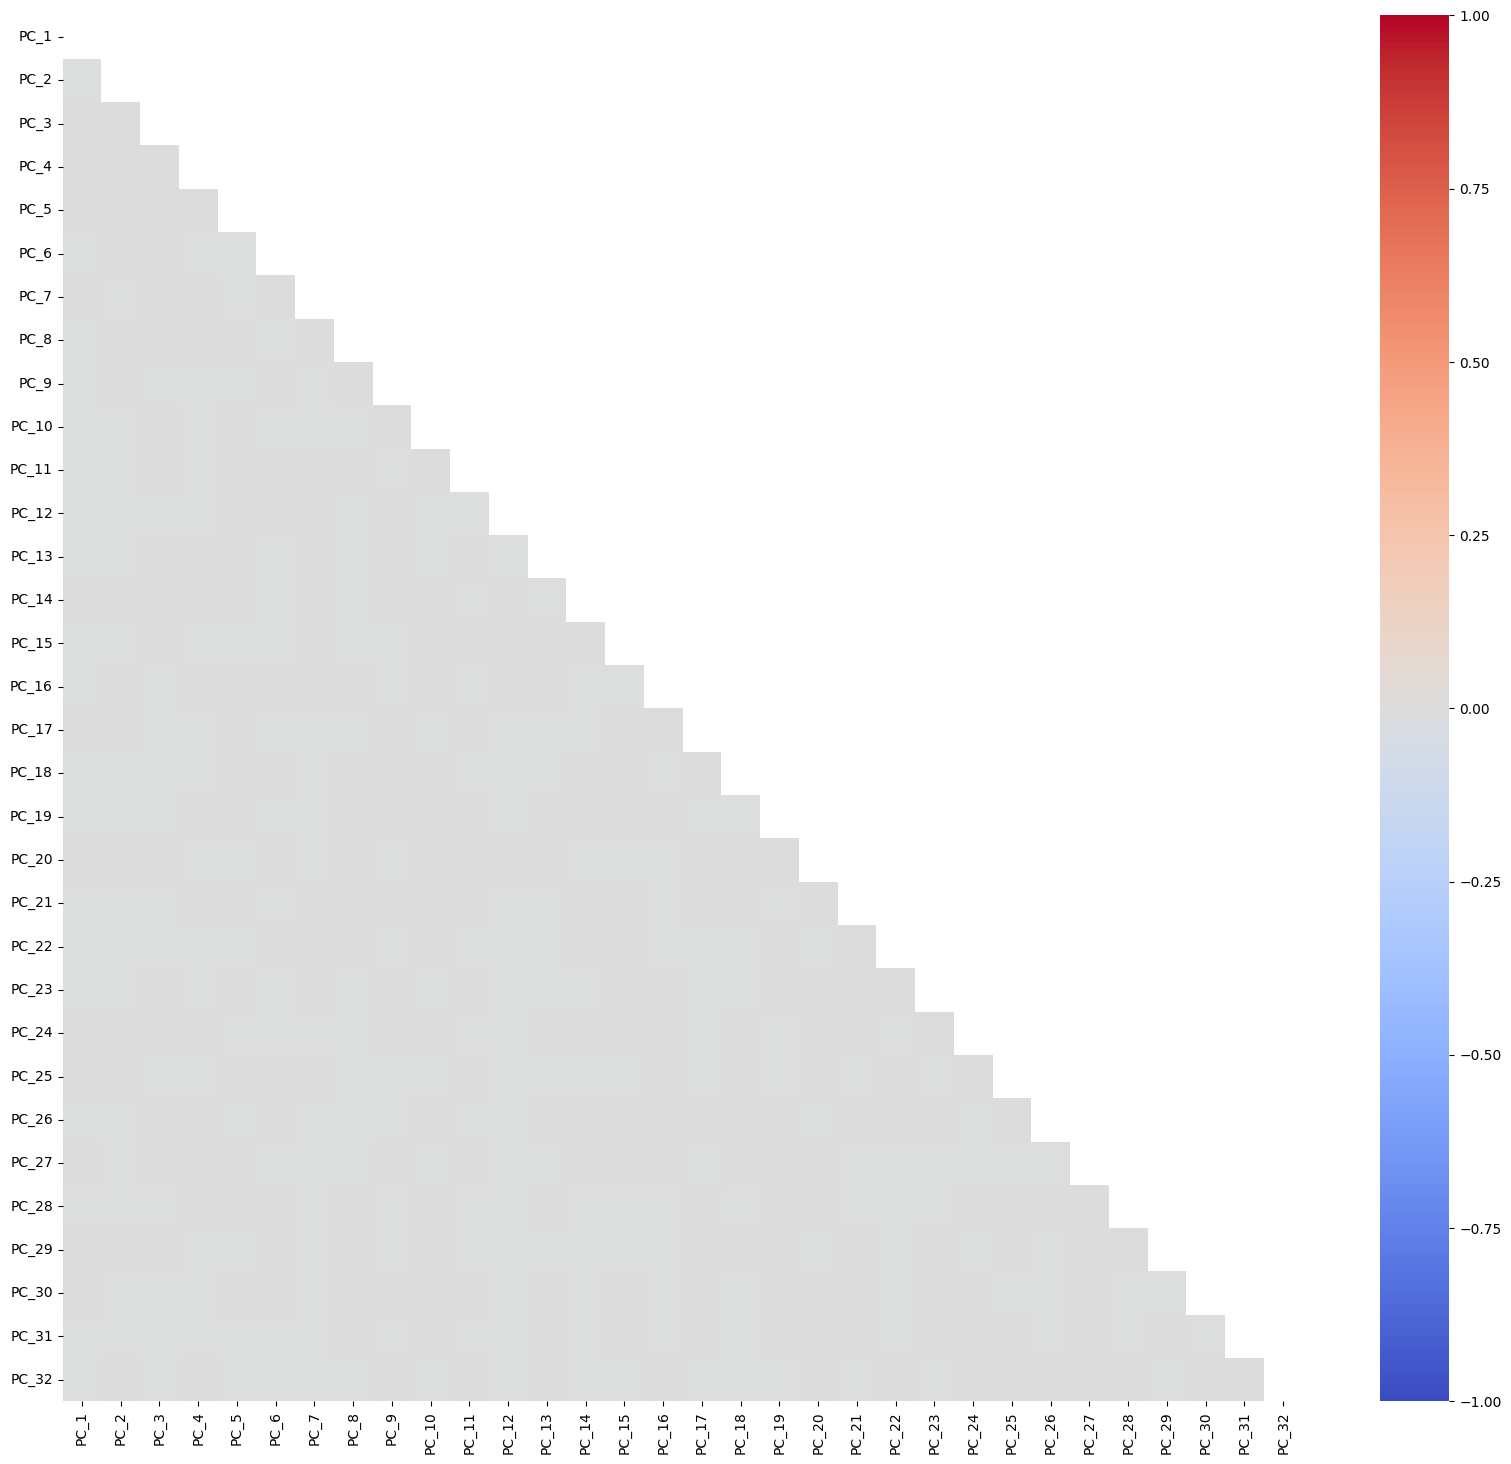

In [127]:
correlation_matrix = X_PCA_frac.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            cmap='coolwarm', 
            annot=False,
            vmin=-1,
            vmax=1,
            center=0)

plt.yticks(rotation=0)
plt.show()

### 5. Feature Selection

#### Heatmaps

Heatmap de X con diferenciación fraccionaria.

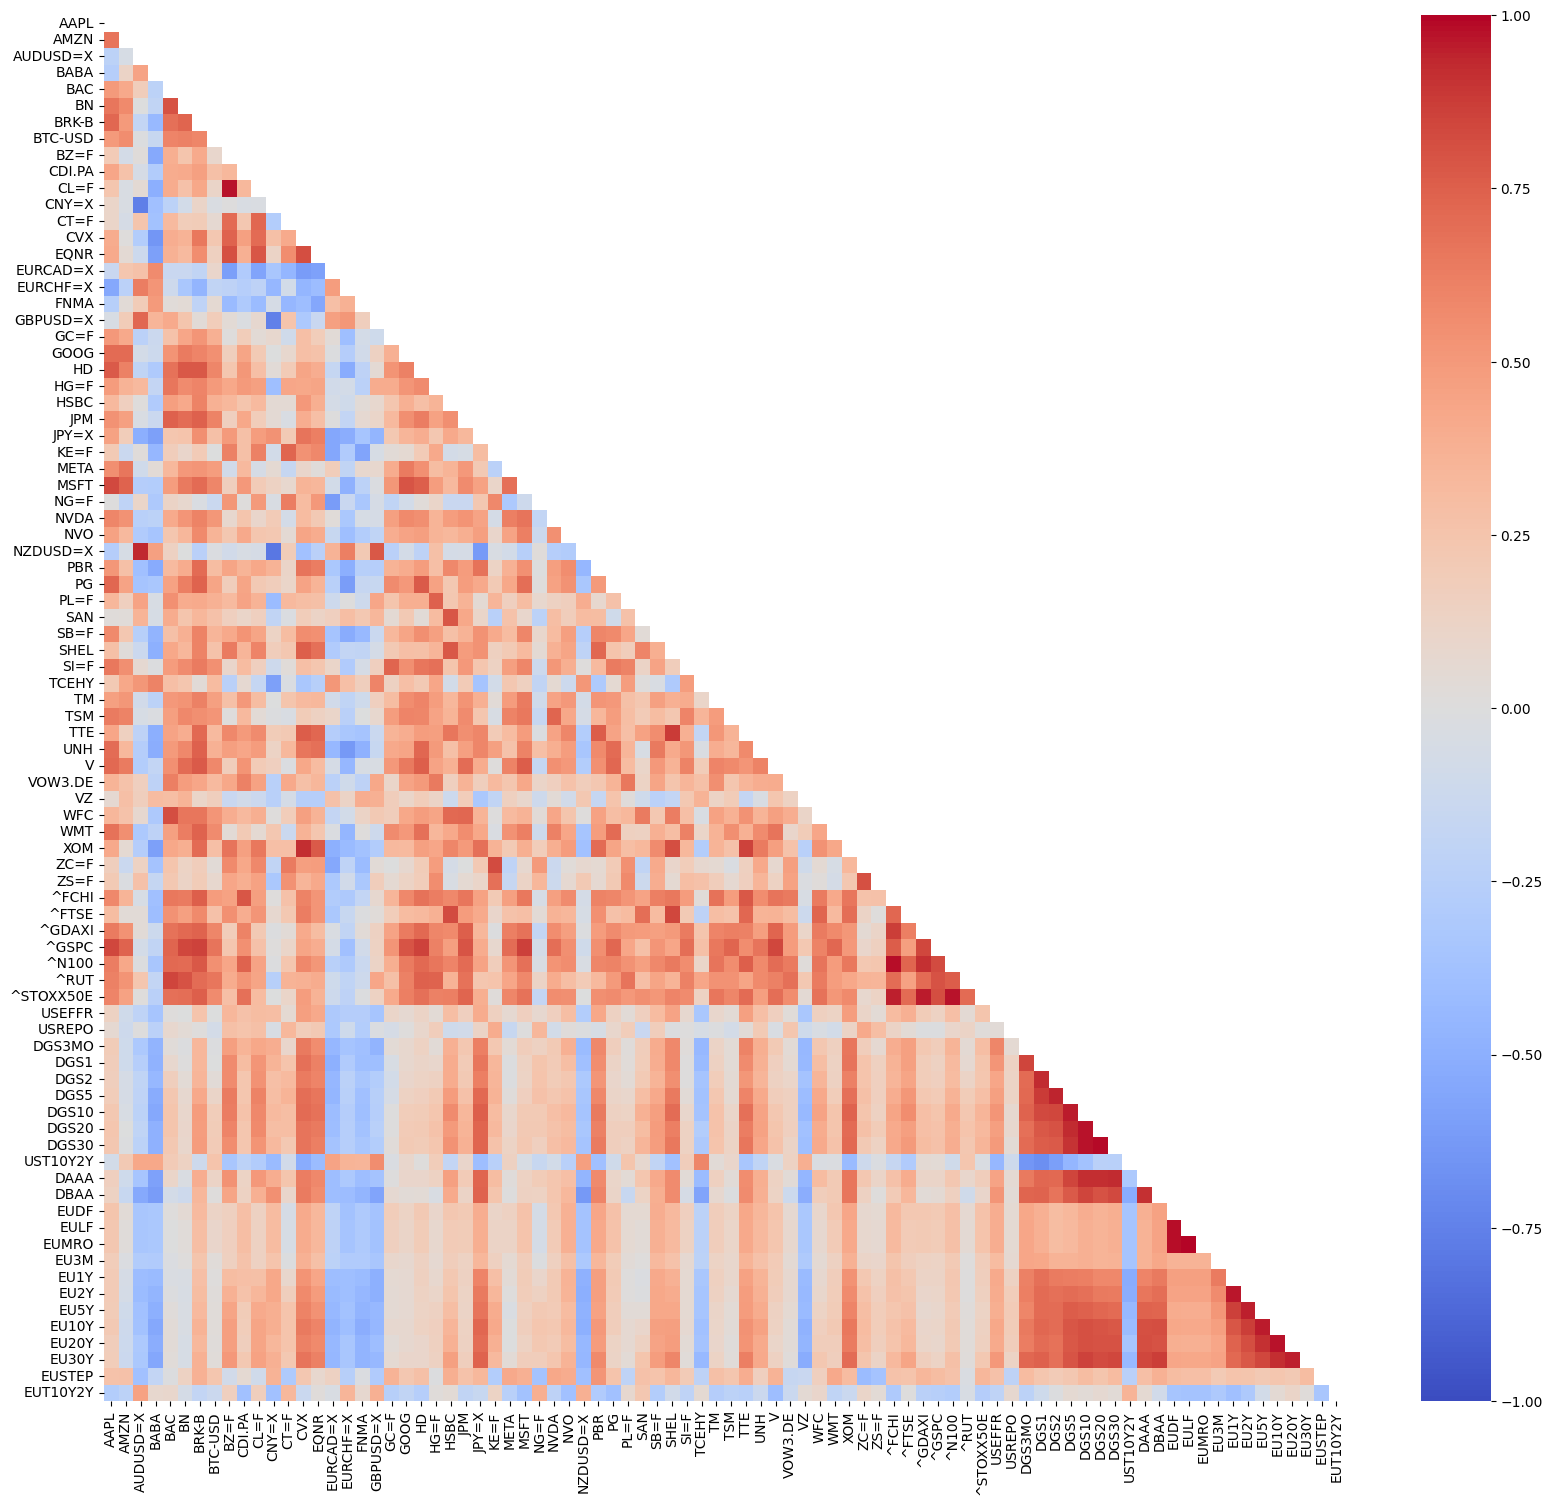

In [132]:
correlation_matrix = X_frac_diff.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            cmap='coolwarm', 
            annot=False,
            vmin=-1,
            vmax=1,
            center=0)

plt.show()

Heatmap de X con diferenciación entera.

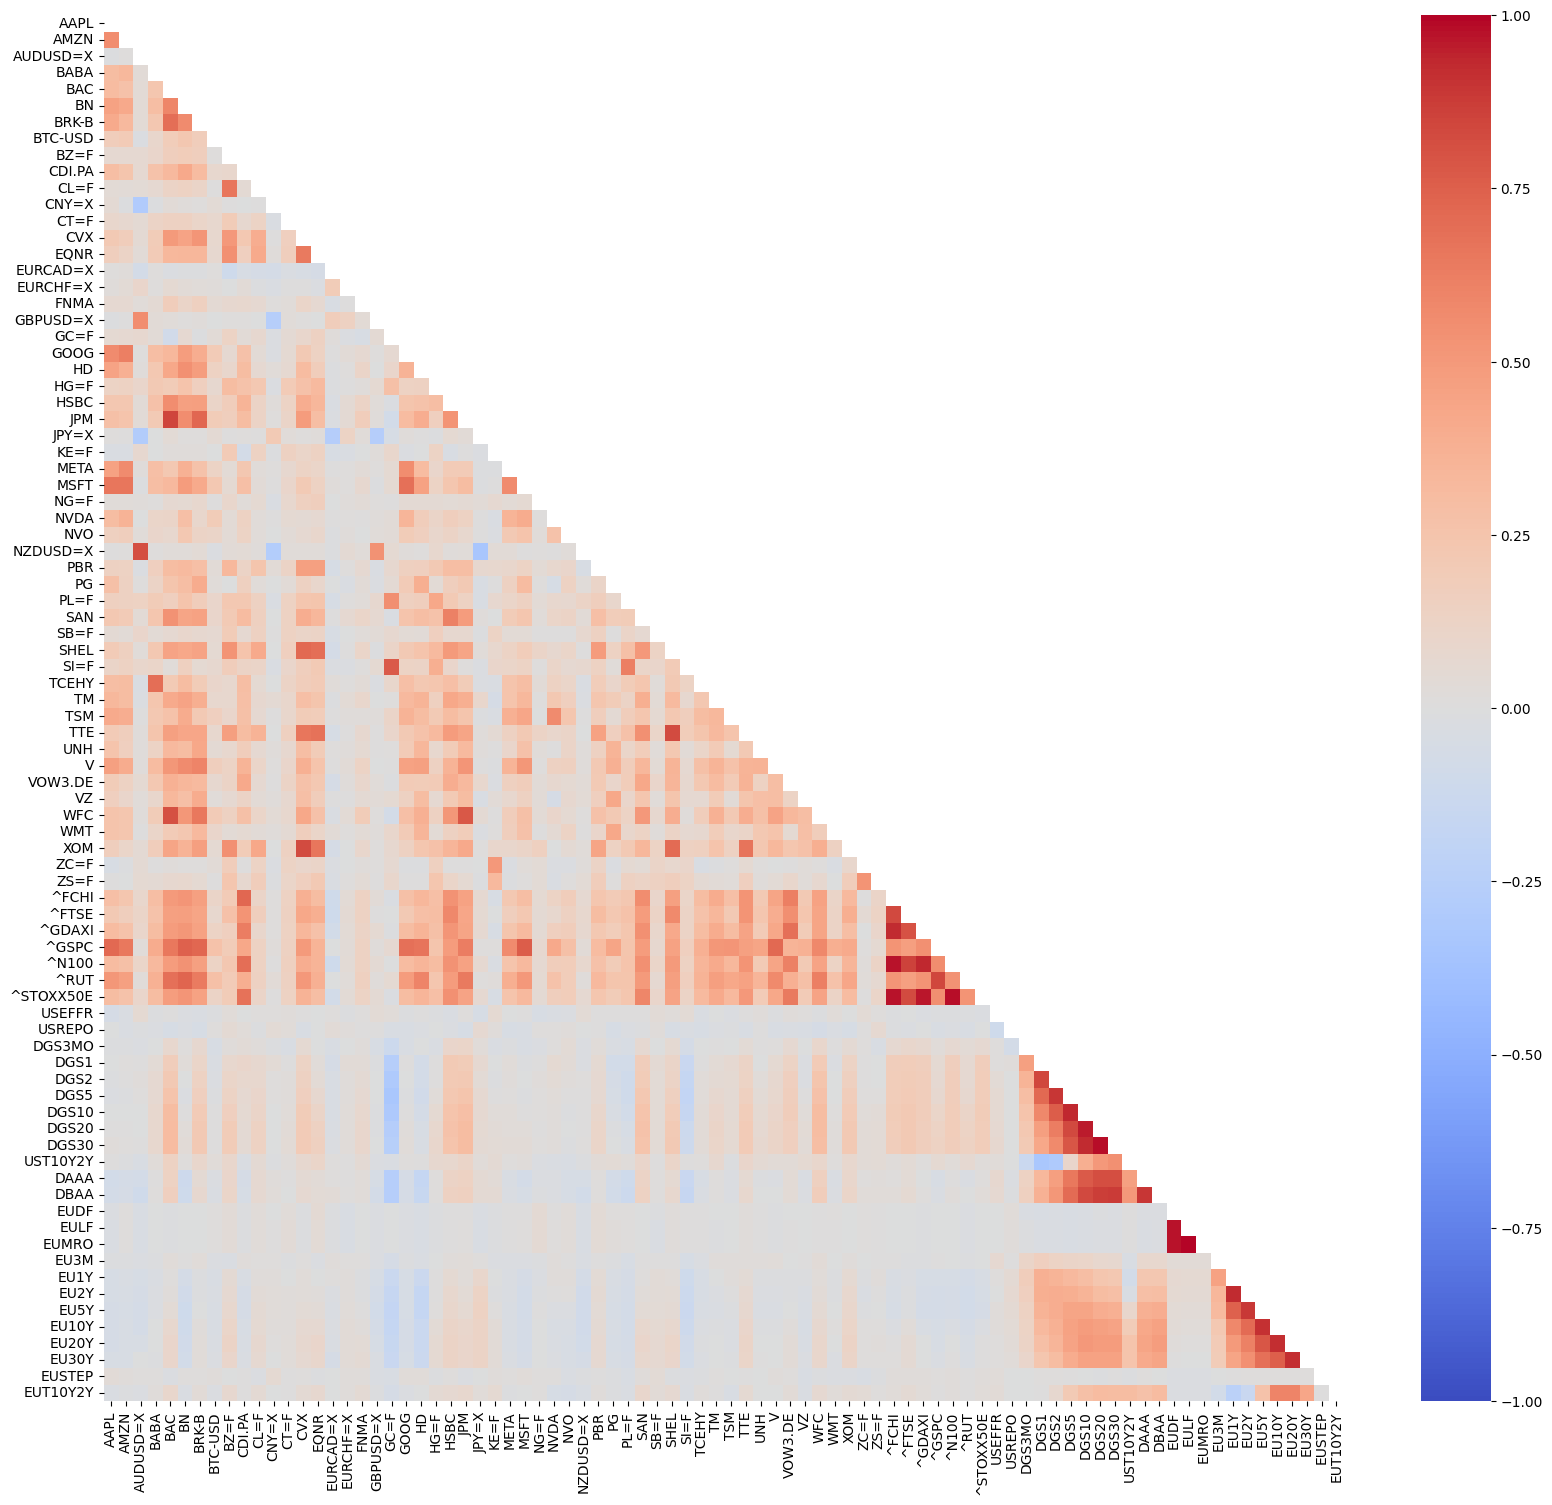

In [135]:
correlation_matrix = X_int_diff.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            cmap='coolwarm', 
            annot=False,
            vmin=-1,
            vmax=1,
            center=0)

plt.show()

#### Mean Decrease Impurity (MDI)

Función para obtener importancia de variables.

In [140]:
def get_MDI(X, y, n_estimators=2500, random_state=False):
    from sklearn.ensemble import RandomForestClassifier

    if random_state is not False:
        rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                          criterion='entropy',
                                          max_features=int(1),
                                          max_samples=1.,
                                          class_weight='balanced',
                                          min_weight_fraction_leaf=0.,
                                          random_state=random_state)
    else:
        rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                          criterion='entropy',
                                          max_features=int(1),
                                          max_samples=1.,
                                          class_weight='balanced',
                                          min_weight_fraction_leaf=0.)
    rf_model.fit(X, y)
    
    
    df0 = {i:tree.feature_importances_ for i, tree in enumerate(rf_model.estimators_)} 
    df0 = pd.DataFrame.from_dict(df0, orient='index', columns=X.columns)
    df0 = df0.replace(0, np.nan)
    
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std() * df0.shape[0] ** -0.5}, axis=1) 
    imp/=imp['mean'].sum()

    return imp

Train Test con Series Temporales financieras sobre `X_frac_diff` y `y_frac`.

In [143]:
def ts_train_test_split(X, y, df=True, test_size=0.2):
    if df == True:
        y = y.loc[X.index]
    
    train_size = 1 - test_size
    tr_split = int((len(X) * train_size))

    X_train, X_test = X[:tr_split], X[tr_split:]
    y_train, y_test = y[:tr_split], y[tr_split:]
        
    return X_train, X_test, y_train, y_test

Dividimos en train test los datos `X` e `y` `orthogonal`.

In [146]:
X_PCA_train_test_frac = ts_train_test_split(X_PCA_frac, y_label.loc[X_PCA_frac.index])

In [147]:
X_PCA_train_test_int = ts_train_test_split(X_PCA_int, y_label.loc[X_PCA_int.index])

Calculamos el MDI para `X_PCA_frac`.

In [150]:
MDI_frac = get_MDI(X_PCA_train_test_frac[0], X_PCA_train_test_frac[2], random_state=seed)

Realizamos lo mismo para el caso de `X_PCA_int`.

In [153]:
MDI_int = get_MDI(X_PCA_train_test_int[0], X_PCA_train_test_int[2], random_state=seed)

Ploteamos el resultado del MDI. Obtenemos variables bastante más relevantes respecto al punto de igualdad teórico.

Importancia de cada componente


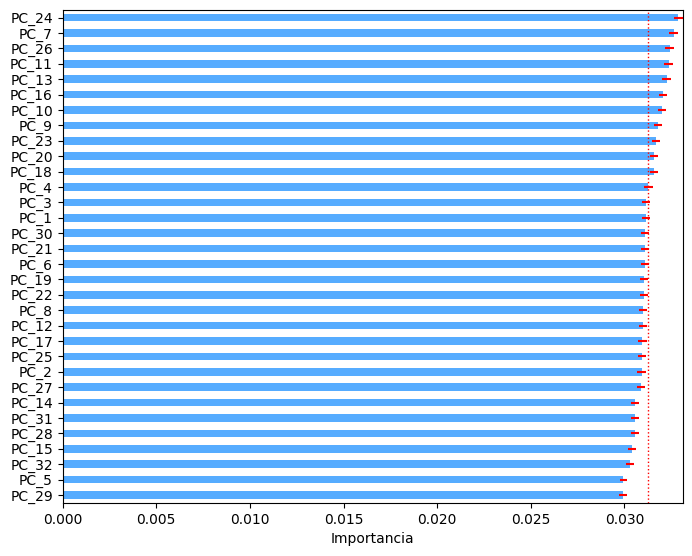

In [156]:
print('Importancia de cada componente')

MDI_plot = MDI_frac.sort_values(by='mean', ascending=True)

imp_prod = (1. / MDI_plot.shape[0])

plt.figure(figsize=(8, MDI_plot.shape[0]/5.)) 
ax = MDI_plot['mean'].plot(kind='barh', color='dodgerblue', alpha=0.75, xerr=MDI_plot['std'], error_kw={'ecolor':'red'})
plt.axvline(imp_prod, linewidth=1, color='red', linestyle='dotted')

plt.xlim([0, MDI_plot.sum(axis=1).max()])
plt.xlabel('Importancia')
plt.show()

Filtramos los activos que aportan de forma media más que el punto teórico medio (linea roja vertical) en todos los casos, considerando desviación estándar.

In [159]:
X_MDI_frac = X_PCA_frac[MDI_frac.query('mean-std > @imp_prod').index.values]

Filtramos con los datos `int` también.

In [162]:
imp_int_prod = (1. / MDI_int.shape[0])

X_MDI_int = X_PCA_int[MDI_int.query('mean-std > @imp_int_prod').index.values]

#### Comparación PCA con MDI

Comparación de los resultados `frac`.

In [166]:
vals_mix_frac = pd.DataFrame(columns=['eVal PCA', 'rank PCA', 'rank MDI','MDI'], index=eVal.index)
vals_mix_frac['eVal PCA'] = eVal_plot
vals_mix_frac['rank PCA'] = vals_mix_frac['eVal PCA'].rank(method='first', ascending=False).astype(int)
vals_mix_frac['MDI'] = MDI_frac['mean']
vals_mix_frac['rank MDI'] = vals_mix_frac['MDI'].rank(method='first', ascending=False).astype(int)
vals_mix_frac

,eVal PCA,rank PCA,rank MDI,MDI
PC_1,0.359443,1,14,0.031149
PC_2,0.184100,2,24,0.030911
PC_3,0.097998,3,13,0.031160
PC_4,0.065931,4,12,0.031282
PC_5,0.037186,5,31,0.029942
PC_6,0.034148,6,17,0.031074
PC_7,0.021468,7,2,0.032638
PC_8,0.018854,8,20,0.031007
PC_9,0.017990,9,8,0.031793
PC_10,0.015127,10,7,0.032009


Correlación entre MDI y rango PCA mediante Weighted Tau y scatter plot sobre `X_frac_diff`.

In [169]:
MDI_imp = np.array(vals_mix_frac['MDI'])
ortogonal_rank = np.array(vals_mix_frac['rank PCA'])
wt = np.round(weightedtau(MDI_imp, ortogonal_rank**-1.)[0], 2)
normal_corr = np.round(np.corrcoef(MDI_imp, ortogonal_rank**-1.)[0, 1], 2)

Pearson: -0.05, weighted Kendall Tau: 0.02


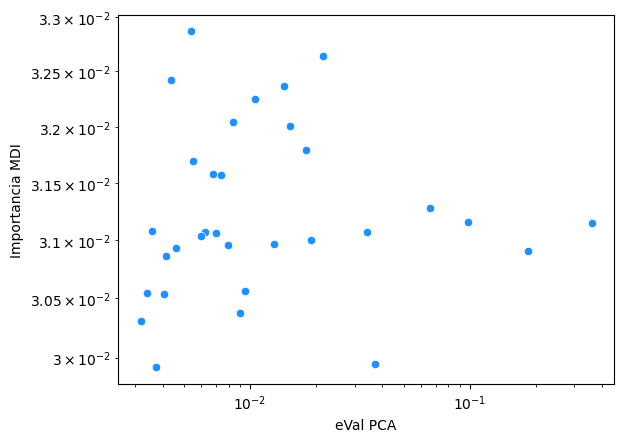

In [170]:
print(f"Pearson: {normal_corr}, weighted Kendall Tau: {wt}")

sns.scatterplot(data=vals_mix_frac, x='eVal PCA', y='MDI', color='dodgerblue')
plt.ylabel('Importancia MDI')
plt.xscale('log')
plt.yscale('log')
plt.show()

Correlación entre MDI y rango PCA mediante Weighted Tau y scatter plot sobre `X_int_diff`.

In [173]:
eVal_int = orthoFeats(X_int_diff, varThres=0.95, eVl=True)
eVal_int = eVal_int / eVal_int.sum()
eVal_plot_int = eVal_int.sort_values(ascending=True)

In [174]:
vals_mix_int = pd.DataFrame(columns=['eVal PCA', 'rank PCA', 'rank MDI','MDI'], index=eVal.index)
vals_mix_int['eVal PCA'] = eVal_int
vals_mix_int['rank PCA'] = vals_mix_int['eVal PCA'].rank(method='first', ascending=False).astype(int)
vals_mix_int['MDI'] = MDI_int['mean']
vals_mix_int['rank MDI'] = vals_mix_int['MDI'].rank(method='first', ascending=False).astype(int)
vals_mix_int

,eVal PCA,rank PCA,rank MDI,MDI
PC_1,0.193558,1,10,0.019115
PC_2,0.111361,2,7,0.019626
PC_3,0.051770,3,2,0.022402
PC_4,0.042983,4,1,0.027686
PC_5,0.038506,5,9,0.019268
PC_6,0.035777,6,3,0.020921
PC_7,0.034213,7,26,0.018160
PC_8,0.031492,8,14,0.018655
PC_9,0.028496,9,5,0.019874
PC_10,0.022048,10,15,0.018501


In [175]:
MDI_imp_int = np.array(vals_mix_int['MDI'])
ortogonal_rank_int = np.array(vals_mix_int['rank PCA'])
wt_int = np.round(weightedtau(MDI_imp_int, ortogonal_rank_int**-1.)[0], 2)
normal_corr_int = np.round(np.corrcoef(MDI_imp_int, ortogonal_rank_int**-1.)[0, 1], 2)

Pearson: 0.29, weighted Kendall Tau: 0.52


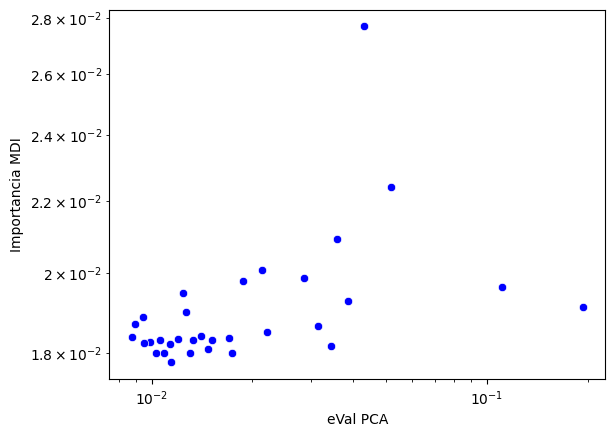

In [176]:
print(f"Pearson: {normal_corr_int}, weighted Kendall Tau: {wt_int}")

sns.scatterplot(data=vals_mix_int, x='eVal PCA', y='MDI', color='blue')
plt.ylabel('Importancia MDI')
plt.xscale('log')
plt.yscale('log')
plt.show()

### 6. Model Training & Evaluation

Creamos un diccionario con los métodos a evaluar.

In [181]:
method_dict = {
    'Integer diff': [X_int_diff, y_label.loc[X_int_diff.index]],
    'Int PCA': [X_PCA_int, y_label.loc[X_PCA_int.index]],
    'Int MDI': [X_MDI_int, y_label.loc[X_MDI_int.index]],
    'Fractional diff': [X_frac_diff, y_label.loc[X_frac_diff.index]],
    'Frac PCA': [X_PCA_frac, y_label.loc[X_PCA_frac.index]],
    'Frac MDI': [X_MDI_frac, y_label.loc[X_MDI_frac.index]]
}

Vemos que las dos clases (0, 1) de `y_label` están balanceadas. Tanto en `train` como en `test`.

In [184]:
split = int(len(X) * 0.8)
print(f"Total: {y_label.value_counts()}, \n\nTrain: {y_label[:split].value_counts()}, \n\nTest: {y_label[split:].value_counts()}")

Total: label
0    1211
1    1168
Name: count, dtype: int64, 

Train: label
0    968
1    935
Name: count, dtype: int64, 

Test: label
0    243
1    233
Name: count, dtype: int64


Creamos una función con las métricas específicas de trading necesarias para evaluar el modelo de clasificación. `CR`: Cummulative Return / Retorno acumulado, `Accuracy`, `Tx`: Transacciones.

In [187]:
def classification_report(df, y_var=False, method=False):
    if y_var is not False:
        y_var['pct_abs'] = data_y['pct_abs'].loc[y_var.index]
        y_var['ret_sig'] = (y_var['Result'] * y_var['pct_abs'])
        CR = np.cumprod(y_var['ret_sig'] + 1).iloc[-1] - 1

        df.loc[method, 'CR'] = str(np.round(CR * 100, 2)) + '%'
        df.loc[method, 'Accuracy'] = np.round(accuracy_score(y_var['label_test'], y_var['label_pred']), 2)
        df.loc[method, 'Tx'] = (y_var['label_pred'] != y_var['label_pred'].shift()).sum()
        return df
            
    else:
        df.insert(0, ' ', '|')
        sep_row = pd.DataFrame([["|", "────", "────", "────"]], columns=df.columns, index=["────────"])
        df = pd.concat([df.iloc[:3], sep_row, df.iloc[3:]])
        return df

Creamos una función para plotear el CR del modelo vs el CR de la estragia hold.

In [190]:
def plot_signals(df):
    df['pct'] = data_y['pct_change'][df.index]

    df['pct_abs'] = data_y['pct_abs'].loc[df.index]
    df['ret_sig'] = (df['Result'] * df['pct_abs'])
    CR = np.cumprod(df['ret_sig'] + 1) - 1
    CR_hold = np.cumprod(df['pct'] + 1) - 1
    
    x = range(len(df['pct'] + 1))
    
    plt.figure(figsize=(8, 4))
    plt.step(x, CR_hold * 100, where='post', color='red', label='Hold CR')
    plt.fill_between(x, CR * 100, step='post', color='chartreuse', alpha=0.3, label='Model CR')
    plt.axhline(0, color='black', linestyle="--", linewidth=1.2)
    
    plt.xlim(0, len(df['pct'] + 1))
    plt.ylabel(f'CR ($\%$)')
    plt.xlabel('Días')
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

#### Modelo de Regresión Logística (LR)

In [193]:
df = pd.DataFrame(index=method_dict.keys(), columns=['CR', 'Accuracy', 'Tx'])
y_var_LR = []
LR_imp_list = []

for method, values in method_dict.items():
    X_n, y_n = values
    X_train, X_test, y_train, y_test = ts_train_test_split(X_n, y_n)
    test_index = X_test.index

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    fX = LogisticRegression(solver='lbfgs', 
                            max_iter=10000, 
                            C=0.01, 
                            random_state=seed)
    fX.fit(X_train, y_train)

    y_pred = fX.predict(X_test)
    
    y_prob = fX.predict_proba(X_test)
    y_var = np.prod(y_prob, axis=1)


    LR_coef = pd.Series(np.abs(fX.coef_[0]), index=X_n.columns)
    LR_imp_list.append(LR_coef)

    
    y_var = pd.DataFrame(y_var, index=test_index, columns=['Uncertainty'])
    y_var['label_test'] = y_test
    y_var['label_pred'] = y_pred
    y_var['Result'] = np.where(y_var['label_test'] == y_var['label_pred'], 1, -1)
    y_var_LR.append(y_var)

    
    classification_report(df, y_var=y_var, method=method)

df = classification_report(df)

df

,,CR,Accuracy,Tx
Integer diff,|,151.25%,0.69,258
Int PCA,|,164.15%,0.68,258
Int MDI,|,146.26%,0.68,253
────────,|,────,────,────
Fractional diff,|,1.45%,0.49,15
Frac PCA,|,29.69%,0.55,73
Frac MDI,|,33.69%,0.57,92


Obtenemos la importancia en el modelo de cada variable.

Regresión Logística: Importancia de cada variable


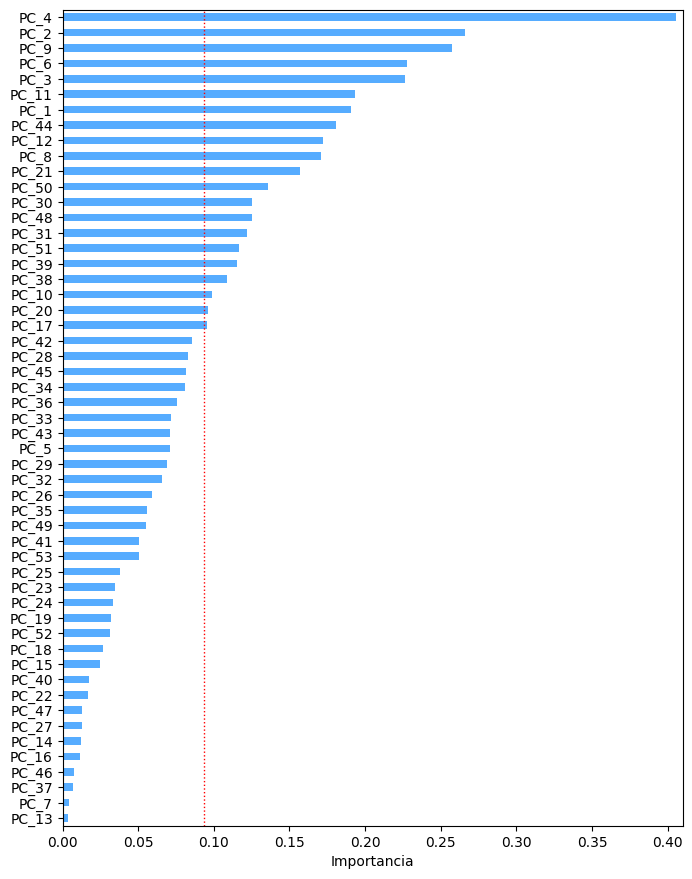

In [197]:
print('Regresión Logística: Importancia de cada variable')

LR_imp = LR_imp_list[1].sort_values(ascending=True)

plt.figure(figsize=(8, LR_imp.shape[0] / 5.)) 
ax = LR_imp.plot(kind='barh', color='dodgerblue', alpha=0.75)
plt.axvline(sum(LR_imp) / LR_imp.shape[0], linewidth=1, color='red', linestyle='dotted')

plt.xlim([0, LR_imp.max()*1.01])
plt.xlabel('Importancia')
plt.show()

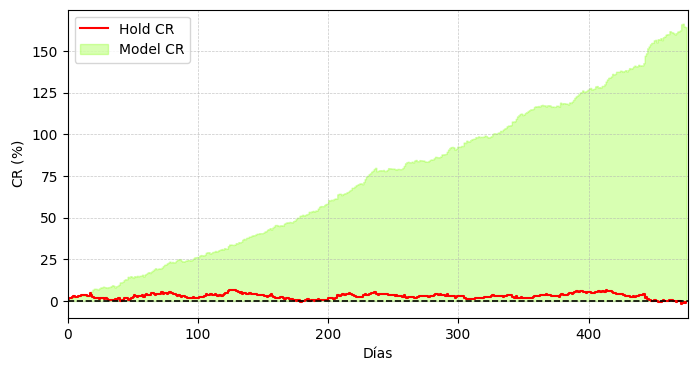

In [199]:
plot_signals(y_var_LR[1])

#### Support Vector Machine (SVM)

In [203]:
df = pd.DataFrame(index=method_dict.keys(), columns=['CR', 'Accuracy', 'Tx'])
y_var_SVM = []
SVM_imp_list = []

for method, values in method_dict.items():
    X_n, y_n = values
    X_train, X_test, y_train, y_test = ts_train_test_split(X_n, y_n)
    test_index = X_test.index

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    fX = SVC(kernel='rbf', 
             C=1.0,
             random_state=seed)
    fX.fit(X_train, y_train)

    y_pred = fX.predict(X_test)
    
    
    y_var = pd.DataFrame(y_pred, index=test_index, columns=['label_pred'])
    y_var['label_test'] = y_test
    y_var['Result'] = np.where(y_var['label_test'] == y_var['label_pred'], 1, -1)
    y_var_SVM.append(y_var)

    
    classification_report(df, y_var=y_var, method=method)

df = classification_report(df)

df

,,CR,Accuracy,Tx
Integer diff,|,113.46%,0.66,246
Int PCA,|,133.09%,0.68,248
Int MDI,|,82.33%,0.62,274
────────,|,────,────,────
Fractional diff,|,9.75%,0.5,104
Frac PCA,|,21.04%,0.5,98
Frac MDI,|,21.72%,0.54,123


#### K-Nearest Neighbors (KNN)

In [294]:
df = pd.DataFrame(index=method_dict.keys(), columns=['CR', 'Accuracy', 'Tx'])
y_var_KNN = []

for method, values in method_dict.items():
    X_n, y_n = values
    X_train, X_test, y_train, y_test = ts_train_test_split(X_n, y_n)
    test_index = X_test.index

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    fX = KNeighborsClassifier(n_neighbors=75, weights='distance')
    fX.fit(X_train, y_train)

    y_pred = fX.predict(X_test)
    
    
    y_var = pd.DataFrame(y_pred, index=test_index, columns=['label_pred'])
    y_var['label_test'] = y_test
    y_var['Result'] = np.where(y_var['label_test'] == y_var['label_pred'], 1, -1)
    y_var_KNN.append(y_var)

    
    classification_report(df, y_var=y_var, method=method)

df = classification_report(df)

df

,,CR,Accuracy,Tx
Integer diff,|,124.86%,0.64,247
Int PCA,|,147.86%,0.67,256
Int MDI,|,103.85%,0.63,246
────────,|,────,────,────
Fractional diff,|,3.36%,0.49,29
Frac PCA,|,17.57%,0.51,102
Frac MDI,|,31.06%,0.58,138


#### Random Forest (RF)

In [210]:
df = pd.DataFrame(index=method_dict.keys(), columns=['CR', 'Accuracy', 'Tx'])
y_var_RF = []
RF_imp_list = []

for method, values in method_dict.items():
    X_n, y_n = values
    X_train, X_test, y_train, y_test = ts_train_test_split(X_n, y_n)
    test_index = X_test.index

    
    fX = RandomForestClassifier(n_estimators=1000, 
                                max_depth=4, 
                                criterion='gini', 
                                max_features='sqrt', 
                                bootstrap=True, 
                                random_state=seed)
    fX.fit(X_train, y_train)
    
    y_pred = fX.predict(X_test)
    
    y_prob = fX.predict_proba(X_test)
    y_var = np.prod(y_prob, axis=1)

    RF_imp_list.append(pd.Series(fX.feature_importances_, index=X_n.columns))
    
    y_var = pd.DataFrame(y_var, index=test_index, columns=['Uncertainty'])
    y_var['label_test'] = y_test
    y_var['label_pred'] = y_pred
    y_var['Result'] = np.where(y_var['label_test'] == y_var['label_pred'], 1, -1)
    y_var_RF.append(y_var)

    
    classification_report(df, y_var=y_var, method=method)

df = classification_report(df)

df

,,CR,Accuracy,Tx
Integer diff,|,131.56%,0.65,240
Int PCA,|,127.42%,0.67,252
Int MDI,|,110.24%,0.65,252
────────,|,────,────,────
Fractional diff,|,-0.97%,0.48,9
Frac PCA,|,41.42%,0.6,119
Frac MDI,|,27.09%,0.57,112


#### XGboost (eXtreme Gradient Boosting) Tree

In [214]:
df = pd.DataFrame(index=method_dict.keys(), columns=['CR', 'Accuracy', 'Tx'])
y_var_XGB = []
XGB_imp_list = []

for method, values in method_dict.items():
    X_n, y_n = values
    X_train, X_test, y_train, y_test = ts_train_test_split(X_n, y_n)
    test_index = X_test.index

    
    fX = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=2,  
        subsample=0.8,   
        colsample_bytree=0.5,
        gamma=10,
        seed=seed)
    fX.fit(X_train, y_train)
    
    y_pred = fX.predict(X_test)
    
    y_prob = fX.predict_proba(X_test)
    y_var = np.prod(y_prob, axis=1)

    XGB_imp_list.append(pd.Series(fX.feature_importances_, index=X_n.columns))
    
    y_var = pd.DataFrame(y_var, index=test_index, columns=['Uncertainty'])
    y_var['label_test'] = y_test
    y_var['label_pred'] = y_pred
    y_var['Result'] = np.where(y_var['label_test'] == y_var['label_pred'], 1, -1)
    y_var_XGB.append(y_var)

    
    classification_report(df, y_var=y_var, method=method)

df = classification_report(df)

df

,,CR,Accuracy,Tx
Integer diff,|,150.23%,0.68,247
Int PCA,|,136.67%,0.67,257
Int MDI,|,129.68%,0.65,253
────────,|,────,────,────
Fractional diff,|,1.73%,0.49,15
Frac PCA,|,23.07%,0.57,108
Frac MDI,|,23.44%,0.57,110


Obtenemos la importancia en el modelo de cada variable.

eXtreme Gradient Boosting Tree: Importancia de cada variable


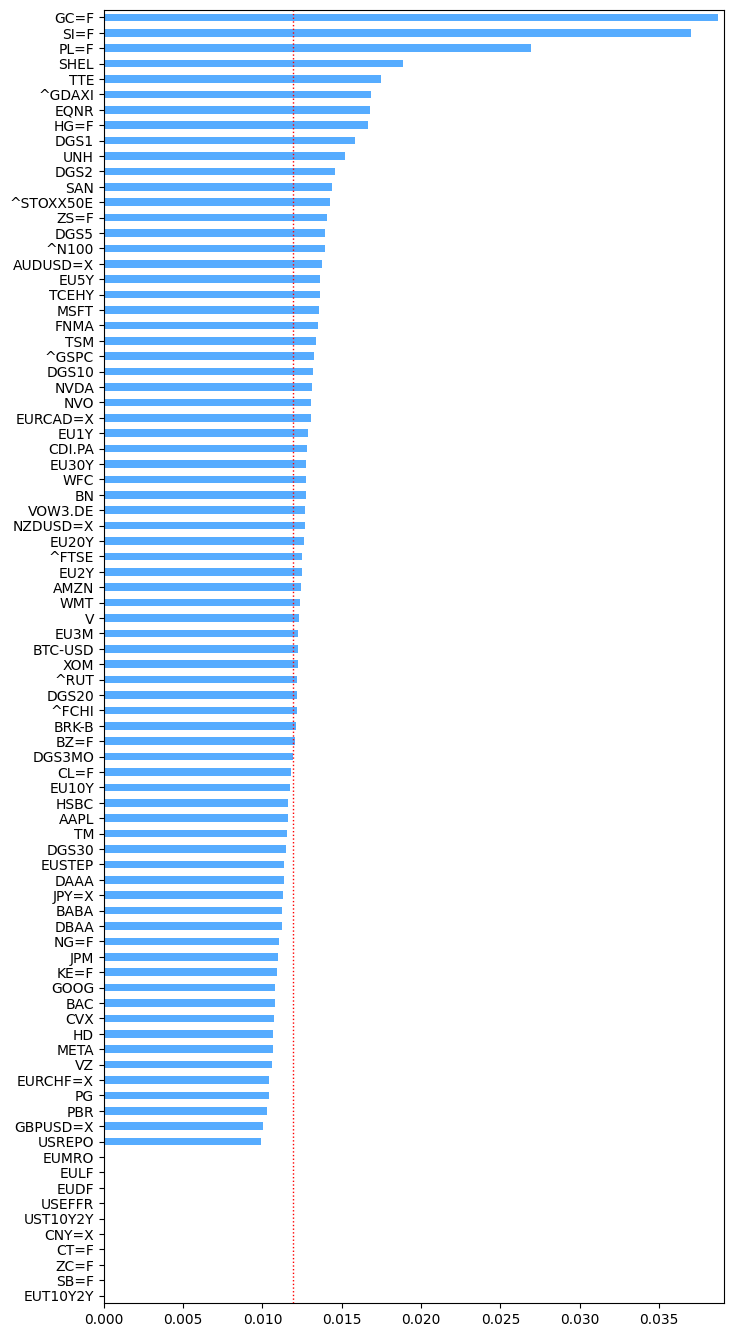

In [217]:
print('eXtreme Gradient Boosting Tree: Importancia de cada variable')

XGB_imp = XGB_imp_list[0].sort_values(ascending=True)

plt.figure(figsize=(8, XGB_imp.shape[0] / 5.)) 
ax = XGB_imp.plot(kind='barh', color='dodgerblue', alpha=0.75)
plt.axvline(sum(XGB_imp) / XGB_imp.shape[0], linewidth=1, color='red', linestyle='dotted')

plt.xlim([0, XGB_imp.max()*1.01])
plt.show()